# Importando conjunto de dados

Como sempre, a preguiça fala mais alto e usamos o requests para requisitar o conjunto de dados ao invés de clicar no link de download.

In [ ]:
import requests, io, zipfile

r = requests.get('https://s3.amazonaws.com/caelum-online-public/1119-time-series-pandas/material/material+curso+-+Time+Series.zip', stream=True)
zip = zipfile.ZipFile(io.BytesIO(r.content))
zip.extractall()

# Alucar - análise de vendas

O primeiro conjunto de dados que nós temos é o de uma linda empresa fictícia de venda de carros, e possui só 2 colunas. A ideia aqui é analisar as vendas dessa empresa.

In [ ]:
import pandas as pd
alucar = pd.read_csv('material curso - Time Series/alucar.csv')
alucar

,mes,vendas
0,2017-01-31,10
1,2017-02-28,20
2,2017-03-31,33
3,2017-04-30,47
4,2017-05-31,63
5,2017-06-30,81
6,2017-07-31,101
7,2017-08-31,124
8,2017-09-30,148
9,2017-10-31,174


Abaixo, vemos que o tipo de dado da coluna mês é `object`. No entanto, quando trabalhamos com séries temporais é importante que a coluna de data tenha o formato `datetime`.

In [ ]:
alucar.dtypes

mes       object
vendas     int64
dtype: object

Por isso, temos que transformá-la em datetime. Podemos fazer isso com a função `to_datetime` do pandas.

In [ ]:
alucar['mes'] = pd.to_datetime(alucar['mes'])
alucar.dtypes

mes       datetime64[ns]
vendas             int64
dtype: object

O gráfico a seguir ficou muito bonito e eu adorei aprender os macetes do seaborn que nunca tinha aprendido para deixar o gráfico bonitão desse jeito.

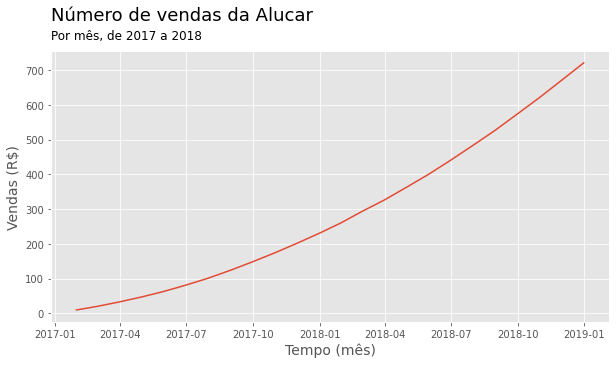

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

p = sns.lineplot(x=alucar['mes'], 
                 y=alucar['vendas'])
p.figure.set_size_inches(10, 5)
p.set_title('Número de vendas da Alucar', loc='left', fontsize=18, pad=30)
p.figure.text(x=0.125, y=0.91, s='Por mês, de 2017 a 2018', fontsize=12)
p.set_xlabel('Tempo (mês)', fontsize=14)
p.set_ylabel('Vendas (R$)', fontsize=14)
p = p

Temos o número de vendas, mas podemos fazer uma *decomposição* dessa série temporal para nos dar insights. A seguir, fazemos a decomposição das vendas para ver o aumento de vendas por mês. Podemos utilizar a função `diff`.

In [ ]:
alucar['aumento'] = alucar['vendas'].diff()
alucar.head()

,mes,vendas,aumento
0,2017-01-31,10,NaN
1,2017-02-28,20,10.0
2,2017-03-31,33,13.0
3,2017-04-30,47,14.0
4,2017-05-31,63,16.0


Vemos que, de fato, todos os meses tiveram um aumento positivo. No entanto, fica mais claro que o aumento em alguns meses foi maior do que em outros, evidenciado pelo ângulo da linha. Criamos uma função para plotagem, para facilitar nossa vida.

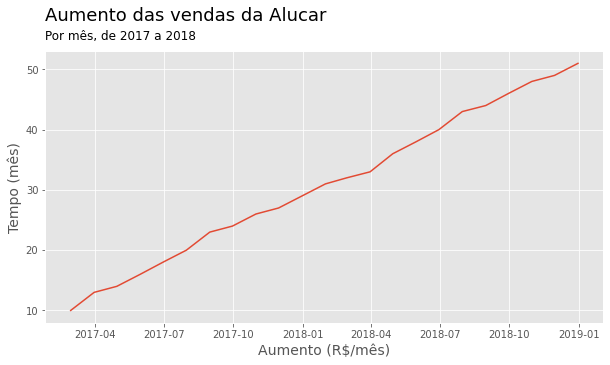

In [ ]:
def grafico(dataset, x, y, titulo, subtitulo, labels):
  p = sns.lineplot(x=dataset[x], 
                  y=dataset[y])
  p.figure.set_size_inches(10, 5)
  p.set_title(titulo, loc='left', fontsize=18, pad=30)
  p.figure.text(x=0.125, y=0.91, s=subtitulo, fontsize=12)
  p.set_xlabel(labels[0], fontsize=14)
  p.set_ylabel(labels[1], fontsize=14)
  return p

p = grafico(alucar, 'mes', 'aumento', 'Aumento das vendas da Alucar', 'Por mês, de 2017 a 2018', labels=['Aumento (R$/mês)', 'Tempo (mês)'])

Para ganhar ainda mais insights sobre o comparativo entre os meses, podemos decompor novamente nossa série temporal para descobrir a sua aceleração de crescimento.

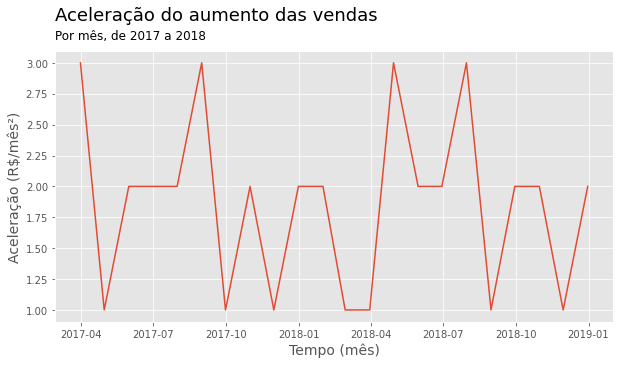

In [ ]:
alucar['aceleração'] = alucar['aumento'].diff()
p = grafico(alucar, 'mes', 'aceleração', 'Aceleração do aumento das vendas', 'Por mês, de 2017 a 2018', ['Tempo (mês)', 'Aceleração (R$/mês²)'])

É importante notar que o eixo y nunca é negativo, ou seja, em nenhum mês as vendas pararam de crescer.

Para facilitar nossa vida, vamos criar uma função que já plota os 3 gráficos de uma vez.

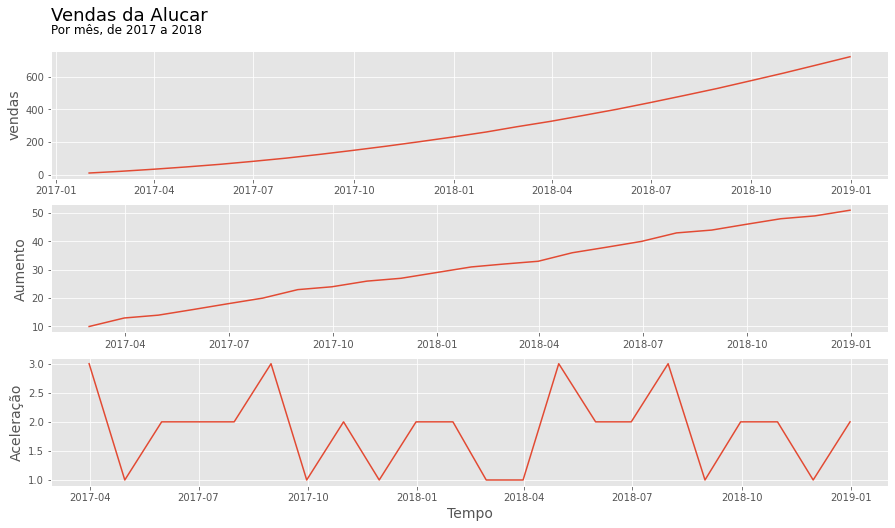

In [ ]:
def comparacao_timeseries(dados, coluna_analise, coluna_tempo, titulo, subtitulo):
  dados[coluna_analise+'_aumento'] = dados[coluna_analise].diff()
  dados[coluna_analise+'_aceleração'] = dados[coluna_analise+'_aumento'].diff()

  ax = plt.subplot(3, 1, 1)
  ax = grafico(dados, coluna_tempo, coluna_analise, titulo, subtitulo, labels=['', coluna_analise])
  ax.figure.set_size_inches(15, 8)

  ax2 = plt.subplot(3, 1, 2)
  ax2 = grafico(dados, coluna_tempo, coluna_analise+'_aumento', '', '', labels=['', 'Aumento'])
  ax2.figure.set_size_inches(15, 8)

  ax3 = plt.subplot(3, 1, 3)
  ax3 = grafico(dados, coluna_tempo, coluna_analise+'_aceleração', '', '', labels=['Tempo', 'Aceleração'])
  ax3.figure.set_size_inches(15, 8)

comparacao_timeseries(alucar, 'vendas', 'mes', 'Vendas da Alucar', 'Por mês, de 2017 a 2018')



Podemos ver também o gráfico de autocorrelação da série temporal. A autocorrelação é uma medida que determina o quanto o valor de uma variável aleatória é capaz de influenciar os seus vizinhos ao longo do tempo. No eixo y, temos o valor da correlação, e no x, o passar do tempo. A ideia é a seguinte: vamos pegar um mês qualquer e determinar o quanto ele influencia os outros meses.

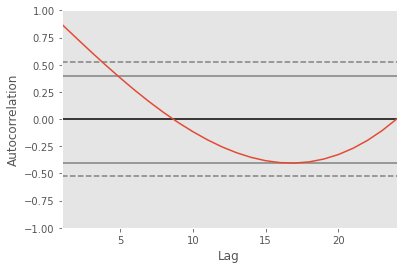

In [ ]:
autocor = pd.plotting.autocorrelation_plot(alucar['vendas'])

Durante os primeiros ~5 meses (o `Lag` determina quantos "passos" se passaram;  nesse caso, meses), podemos ver que as vendas são fortemente correlacionadas. Isso quer dizer, por exemplo, que se quisermos prever as vendas do próximo mês utilizando os 5 últimos meses, provavelmente estaremos bem perto do resultado real.

No entanto, depois de 5 ou 10 meses, a autocorrelação já é menor. Após o Lag 10, a autocorrelação aumenta em valor absoluto, porém na direção contrária (ou seja, negativa), até que volta a cair e termina em 0.

Podemos plotar também a autocorrelação das decomposições, e como isso vai ser útil, vamos criar outra função para plotar os 3 de uma vez só.

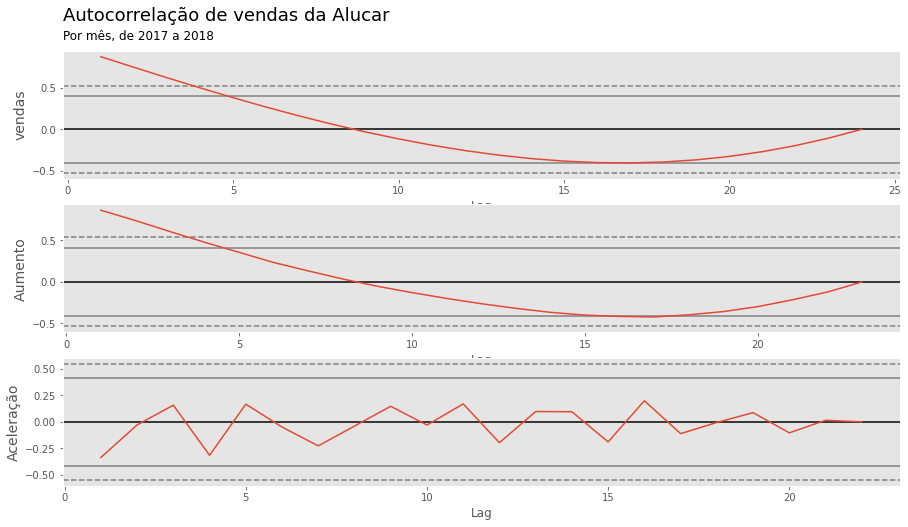

In [ ]:
def comparacao_autocorrelacao(dados, coluna_analise, titulo, subtitulo):
  dados[coluna_analise+'_aumento'] = dados[coluna_analise].diff()
  dados[coluna_analise+'_aceleração'] = dados[coluna_analise+'_aumento'].diff()

  plt.figure(figsize=(15, 8))

  ax = plt.subplot(3, 1, 1)
  a = pd.plotting.autocorrelation_plot(dados[coluna_analise], ax=ax)
  a.set_title(titulo, loc='left', fontsize=18, pad=30)
  a.figure.text(x=0.125, y=0.90, s=subtitulo, fontsize=12)
  a.set_ylabel(coluna_analise, fontsize=14)

  ax2 = plt.subplot(3, 1, 2)
  b = pd.plotting.autocorrelation_plot(dados[coluna_analise+'_aumento'][1:], ax=ax2)
  b.set_ylabel('Aumento', fontsize=14)

  ax3 = plt.subplot(3, 1, 3)
  c = pd.plotting.autocorrelation_plot(dados[coluna_analise+'_aceleração'][2:], ax=ax3)
  c.set_ylabel('Aceleração', fontsize=14)

comparacao_autocorrelacao(alucar, 'vendas', 'Autocorrelação de vendas da Alucar', 'Por mês, de 2017 a 2018')

# Alucar - análise de assinantes da newsletter

Vamos repetir a mesma análise, porém agora com um conjunto de dados diferente, e tentar ganhar insights novos utilizando as mesmas técnicas. A seguir, importamos o conjunto de dados da newsletter da Alucar.

In [ ]:
assinantes = pd.read_csv('material curso - Time Series/newsletter_alucar.csv')
assinantes

,mes,assinantes
0,2017-01-31,0
1,2017-02-28,10
2,2017-03-31,21
3,2017-04-30,34
4,2017-05-31,49
5,2017-06-30,66
6,2017-07-31,85
7,2017-08-31,107
8,2017-09-30,132
9,2017-10-31,160


Primeiro, como na análise anterior, conferimos os dtypes e, vendo a necessidade de arrumá-los, já alteramos na célula seguinte.

In [ ]:
assinantes.dtypes

mes           object
assinantes     int64
dtype: object

In [ ]:
assinantes['mes'] = pd.to_datetime(assinantes['mes'])
assinantes.dtypes

mes           datetime64[ns]
assinantes             int64
dtype: object

Agora, podemos reutilizar a função de comparação feita na primeira análise! Isso facilita muito a nossa vida.

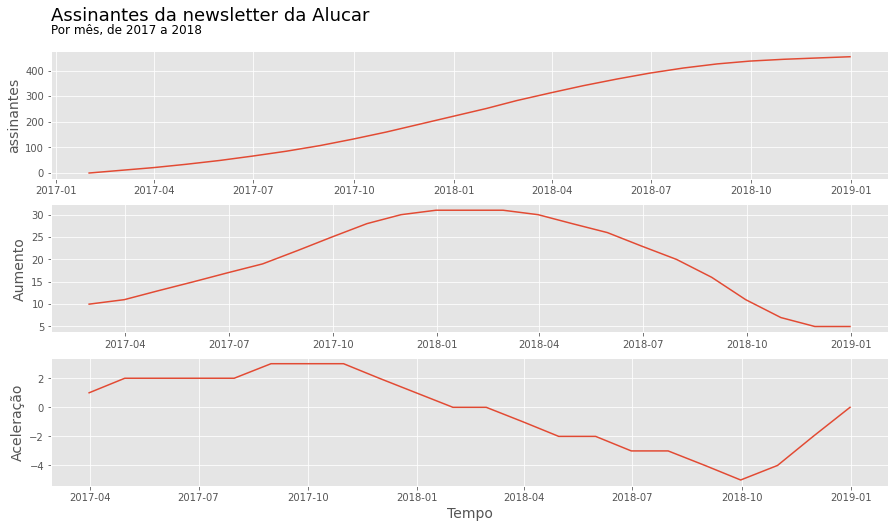

In [ ]:
comparacao_timeseries(assinantes, 'assinantes', 'mes', 'Assinantes da newsletter da Alucar', 'Por mês, de 2017 a 2018')

O gráfico da série temporal "crua" mostra que o número de assinantes cresceu conforme uma função aparentemente sigmoide. Nos primeiros meses, o crescimento foi pequeno; depois disso, houve um período de crescimento acentuado; nos meses finais, no entanto, o crescimento se estagnou. 

O segundo gráfico revela que, de fato, o pico do aumento ocorreu durante os meses de janeiro a abril de 2018. Depois desse período, no entanto, houve uma queda no aumento de assinantes que se estendeu até 2019.

Por sua vez, o gráfico de aceleração deixa claro que houve, a partir de por volta do mês de março de 2018, uma aceleração negativa no número de assinantes. No mês 10, essa aceleração voltou a subir, mas ainda se manteve negativa, ou seja: o número de assinantes continuou caindo, porém num ritmo menos acelerado. Encerramos 2018 com uma aceleração igual a 0.

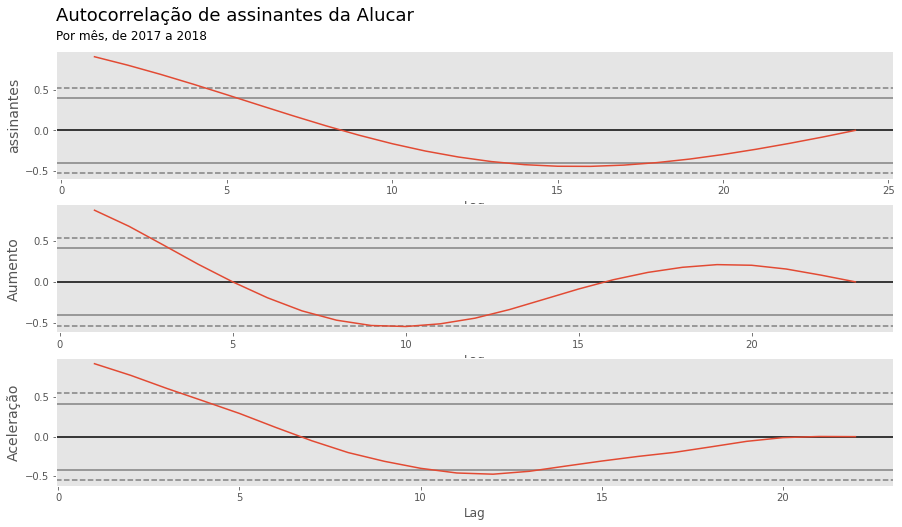

In [ ]:
comparacao_autocorrelacao(assinantes, 'assinantes', 'Autocorrelação de assinantes da Alucar', 'Por mês, de 2017 a 2018')

A autocorrelação para este conjunto de dados específico é baixa. Vemos que a linha vermelha se mantém quase sempre dentro das linhas pontilhadas, entre -0.5 e 0.5, o que anuncia uma autocorrelação não muito relevante. O valor de assinantes da newsletter em um mês não se relaciona tanto com os meses subsequentes.

# Chocolura - análise de vendas

Vamos partir para a análise de um terceiro conjunto de dados. Esta fábrica de chocolate alega não conseguir dar conta de tantas vendas em alguns períodos do ano, porém também conta com baixa procura em outros.

In [ ]:
chocolura = pd.read_csv('material curso - Time Series/chocolura.csv')
chocolura

,mes,vendas
0,2017-01,210
1,2017-02,185
2,2017-03,209
3,2017-04,280
4,2017-05,211
5,2017-06,300
6,2017-07,210
7,2017-08,205
8,2017-09,208
9,2017-10,210


Processo padrão para arrumar os dtypes...

In [ ]:
chocolura.dtypes

mes       object
vendas     int64
dtype: object

In [ ]:
chocolura['mes'] = pd.to_datetime(chocolura['mes'])
chocolura.dtypes

mes       datetime64[ns]
vendas             int64
dtype: object

Só de curiosidade, vamos plotar os gráficos de decomposição e de autocorrelação.

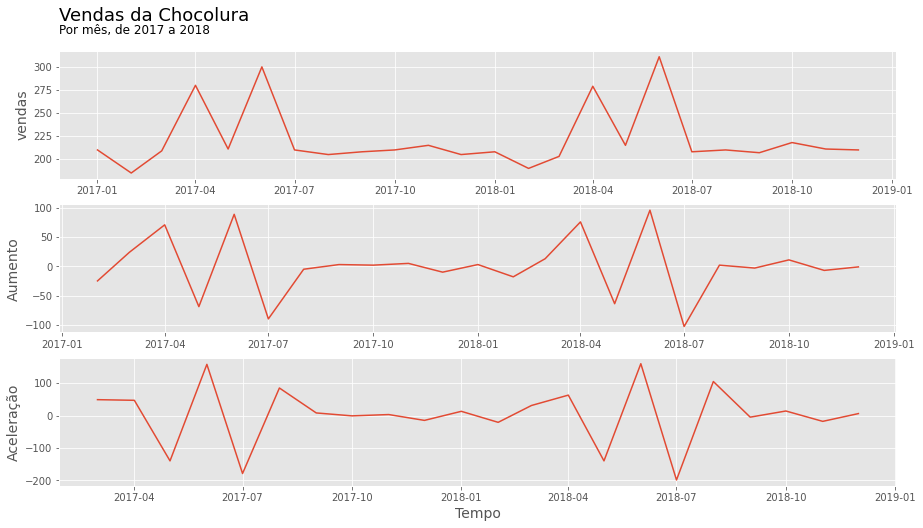

In [ ]:
comparacao_timeseries(chocolura, 'vendas', 'mes', 'Vendas da Chocolura', 'Por mês, de 2017 a 2018')

Vemos um padrão bem interessante nos meses 4 e 6: nos dois anos, tanto de 2018 quanto de 2019, percebemos uma forma bem similar nesses dois picos de vendas. Isso evidencia um padrão de *sazonalidade*, que é basicamente um padrão repetitivo dentro de um determinado período de tempo. Neste conjunto de dados, a sazonalidade é tão forte que ela se manteve até no gráfico de aumento e aceleração!

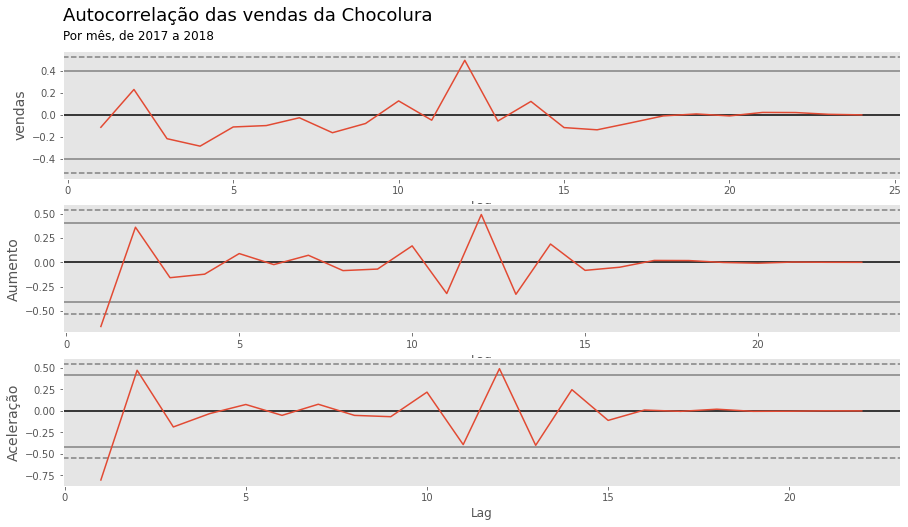

In [ ]:
comparacao_autocorrelacao(chocolura, 'vendas', 'Autocorrelação das vendas da Chocolura', 'Por mês, de 2017 a 2018')

A autocorrelação é bem insignificante mesmo nesse conjunto de dados, em termos absolutos. No entanto, é interessante notar como a sazonalidade se evidencia, também, nesse gráfico! Se tivéssemos dados para mais de um ciclo de sazonalidade, ou seja, mais de um ano, nete caso, poderíamos ver a mesma "forma de onda" que aparece nos Lags 10 a 15. O Lag, neste caso, informa qual é o tamanho do ciclo, ou seja, qual é o período da sazonalidade. No mês 12, vemos que existe um pico de autocorrelação. Isso ocorre justamente porque a sazonalidade nesta série temporal é de 1 ano, ou 12 meses, que é nossa medida de tempo.

Fato curioso: os meses em que ocorrem os picos de venda na Chocolura são em Abril e Junho, em que ocorrem a Páscoa e do Dia dos Namorados, respectivamente. Coincidência? *Acho que não!*

# Chocolura - vendas por dia

Neste outro conjunto de dados da Chocolura, vamos analisar suas vendas diárias.

In [ ]:
vendas_dia = pd.read_csv('material curso - Time Series/vendas_por_dia.csv')
vendas_dia

,dia,vendas
0,2018-10-01,50
1,2018-10-02,48
2,2018-10-03,56
3,2018-10-04,50
4,2018-10-05,51
...,...,...
56,2018-11-26,54
57,2018-11-27,60
58,2018-11-28,49
59,2018-11-29,50


In [ ]:
vendas_dia['dia'] = pd.to_datetime(vendas_dia['dia'])
vendas_dia.dtypes

dia       datetime64[ns]
vendas             int64
dtype: object

No gráfico abaixo, fica bem claro que temos uma forte sazonalidade. No entanto, a tendência aparentemente é constante, ou muito baixa, pelo menos durante o período analisado. A diferença entre tendência e sazonalidade é a seguinte: a tendência é o quanto a nossa onda sobe ou desce. A sazonalidade, por sua vez, é o quanto a nossa onda é ondulada. Pode ser que pra você isso seja muito sem sentido, mas pra mim isso fez todo sentido então é isso.

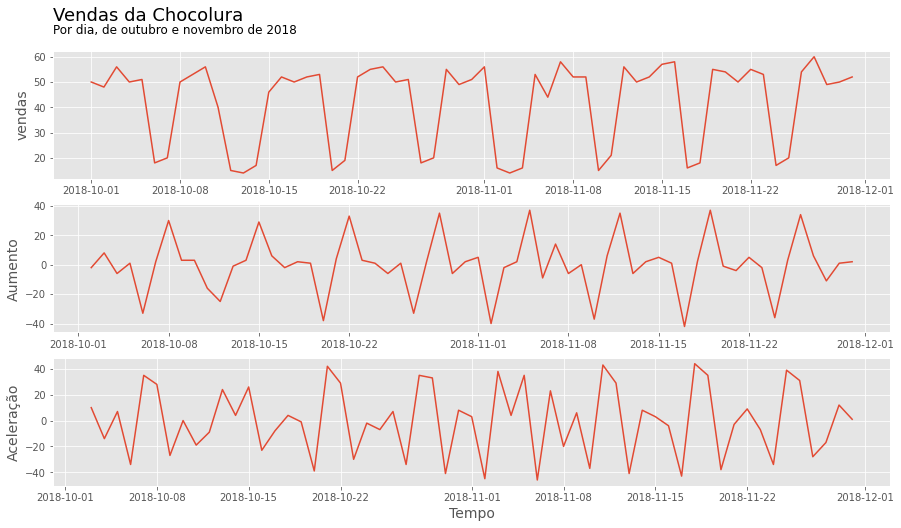

In [ ]:
comparacao_timeseries(vendas_dia, 'vendas', 'dia', 'Vendas da Chocolura', 'Por dia, de outubro e novembro de 2018')

Abaixo, temos um pequeno spoiler (porque o instrutor ainda não fez esse gráfico). Como temos vários ciclos de sazonalidade, fica muito claro identificar o padrão de que a cada 7 dias há um pico de autocorrelação. Incrivelmente, 7 dias é uma semana. Podemos fazer um teste bem simples para provar que este é o período de sazonalidade, e vamos fazer ele depois do gráfico.

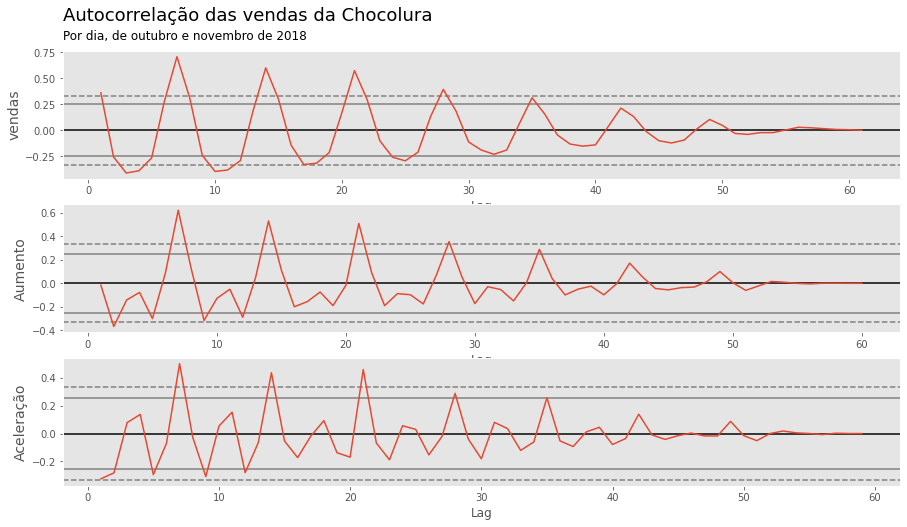

In [ ]:
comparacao_autocorrelacao(vendas_dia, 'vendas', 'Autocorrelação das vendas da Chocolura', 'Por dia, de outubro e novembro de 2018')

Podemos utilizar o datetime do pandas para saber qual dia da semana foi um dia específico. Criamos uma coluna de dia da semana e, a partir disso, podemos agrupar nosso conjunto de dados por ela e ver a média de vendas para cada dia da semana. Vamos usar um heatmap do seaborn para ficar mais fácil de visualizar.

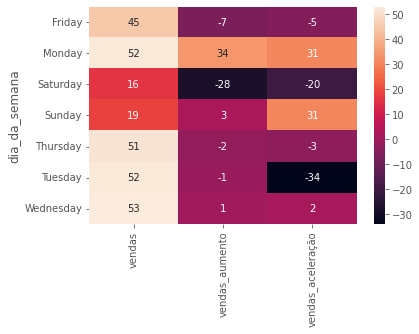

In [ ]:
vendas_dia['dia_da_semana'] = vendas_dia['dia'].dt.day_name()
sns.heatmap(vendas_dia.groupby('dia_da_semana').mean().round(), annot=True)

Fica bem claro que os dias com o menor número de vendas são Sábado e Domingo. Talvez, por alguma regra de negócio, os funcionários trabalhem meio período nesses dias.

# Cafelura - normalização

Uma técnica comum na análise de séries temporais é a normalização. Ela serve para diminuir o ruído de uma série temporal, e ajuda a identificar tendências e sazonalidades que podem ser difíceis de serem encontradas na série crua. Para isso, vamos utilizar o exemplo de conjunto de dados do Cafelura.

In [ ]:
cafelura = pd.read_csv('material curso - Time Series/cafelura.csv')
cafelura['mes'] = pd.to_datetime(cafelura['mes'])
cafelura.head()

,mes,vendas
0,2017-01-31,880
1,2017-02-28,1600
2,2017-03-31,3240
3,2017-04-30,3840
4,2017-05-31,5670


Vemos que as vendas do Cafelura aumentaram nos últimos mesesm, porém o ruído presente na linha pode atrapalhar a análise de velocidade e de aceleração.

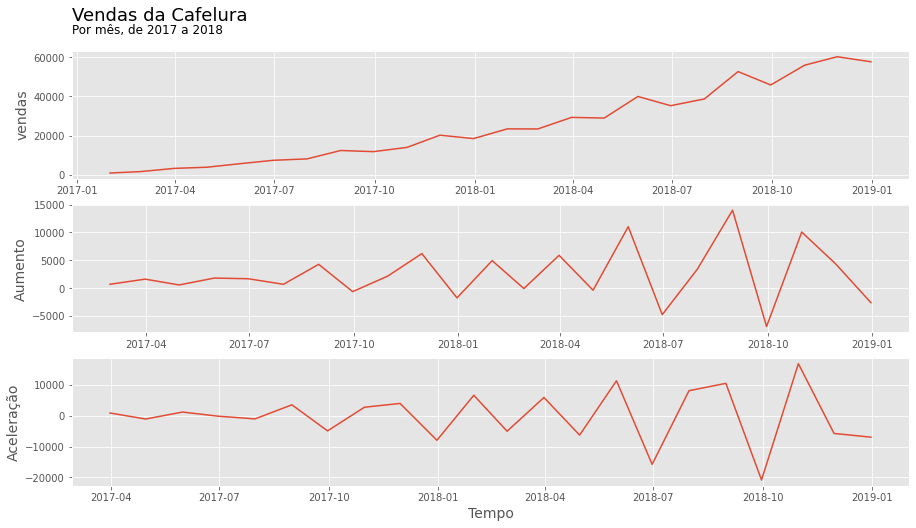

In [ ]:
comparacao_timeseries(cafelura, 'vendas', 'mes', 'Vendas da Cafelura', 'Por mês, de 2017 a 2018')

Uma técnica utilizada para normalizar uma série temporal é dividir o valor analisado pelo número de dias úteis no período de tempo, por exemplo. Neste caso, vamos utilizar o número de finais de semana no período de tempo que, em nosso dataset, é um mês. A seguir, importamos o conjunto de dados com essas informações.

In [ ]:
fim_de_semana = pd.read_csv('material curso - Time Series/dias_final_de_semana.csv')
fim_de_semana.head()

,quantidade_de_dias
0,8
1,8
2,10
3,8
4,9


Agora temos uma coluna normalizada! \o/

In [ ]:
cafelura['vendas_norm'] = cafelura['vendas']/fim_de_semana['quantidade_de_dias']
cafelura.head()

,mes,vendas,vendas_aumento,vendas_aceleração,vendas_norm
0,2017-01-31,880,NaN,NaN,110.0
1,2017-02-28,1600,720.0,NaN,200.0
2,2017-03-31,3240,1640.0,920.0,324.0
3,2017-04-30,3840,600.0,-1040.0,480.0
4,2017-05-31,5670,1830.0,1230.0,630.0


Podemos plotar, e vamos ter uma surpresa:

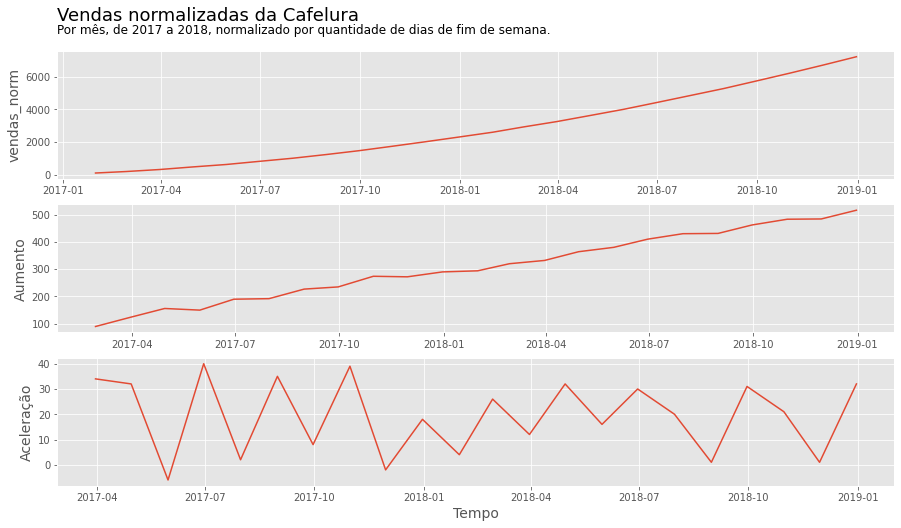

In [ ]:
comparacao_timeseries(cafelura, 'vendas_norm', 'mes', 'Vendas normalizadas da Cafelura', 'Por mês, de 2017 a 2018, normalizado por quantidade de dias de fim de semana.')

A série temporal normalizada é muito mais suave! E, de quebra, agora conseguimos analisar muito melhor o aumento e a aceleração. O aumento agora é uma linha reta bem clara, e vemos que a aceleração é sempre positiva. Por isso, podemos concluir com mais certeza que a empresa está crescendo.

# Interlúdio - Statsmodel

Uma biblioteca legal é a `statsmodel`. Podemos usar sua função de decomposição sazonal para fazer uma análise mais rápida de sazonalidade. Utilizamos o conjunto de dados da Chocolura por mês, aquele que tinha uma sazonalidade de um ano. Colocamos a frequência 12 justamente por isso.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


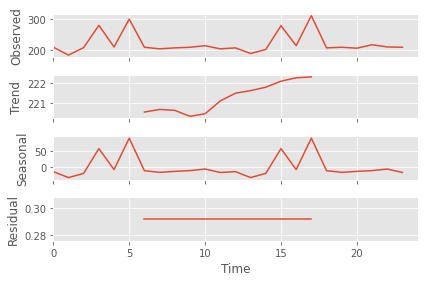

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
resultado = seasonal_decompose([chocolura['vendas']], freq=12).plot()

Vemos como é claro que a sazonalidade tem um ciclo de exatamente 12 meses. A tendência é uma linha com uma direção muito clara e sem ruídos, e o residual é constante.

# Média móvel

Uma ferramenta muito importante na análise de séries temporais é a média móvel. Assim como a normalização, ela nos ajuda a amenizar o ruído e encontrar as tendências da nossa série temporal. O pandas já tem uma função que calcula a média móvel, a `rolling`. Para isso, vamos usar o conjunto de dados alucel.

In [ ]:
alucel = pd.read_csv('material curso - Time Series/alucel.csv')
alucel['dia'] = pd.to_datetime(alucel['dia'])
alucel.head()

,dia,vendas
0,2018-10-01,1374.83
1,2018-10-02,2185.69
2,2018-10-03,1860.36
3,2018-10-04,1939.02
4,2018-10-05,1946.17


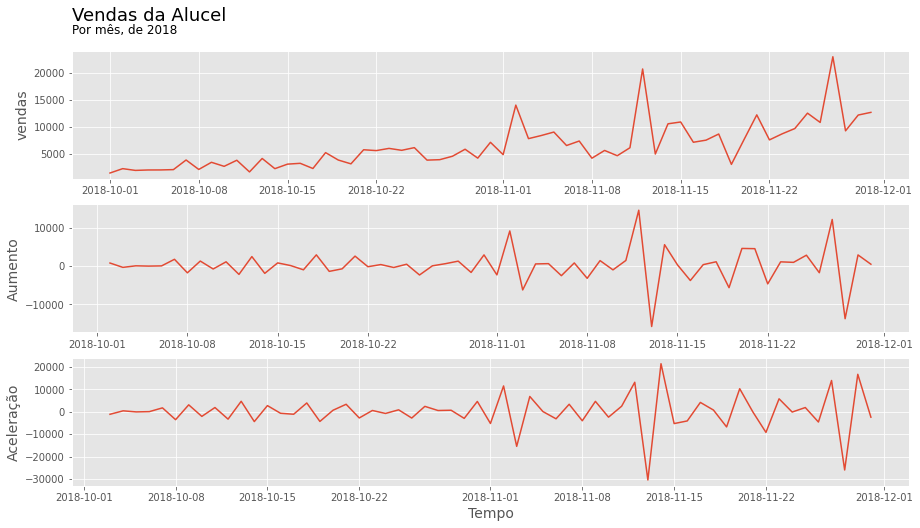

In [ ]:
comparacao_timeseries(alucel, 'vendas', 'dia', 'Vendas da Alucel', 'Por mês, de 2018')

Vemos que existe sim alguma tendência na série, porém ela é muito ruidosa, então é difícil determinar uma tendência com clareza. Para isso, vamos utilizar a média móvel do pandas, olhando para os últimos 7 dias.

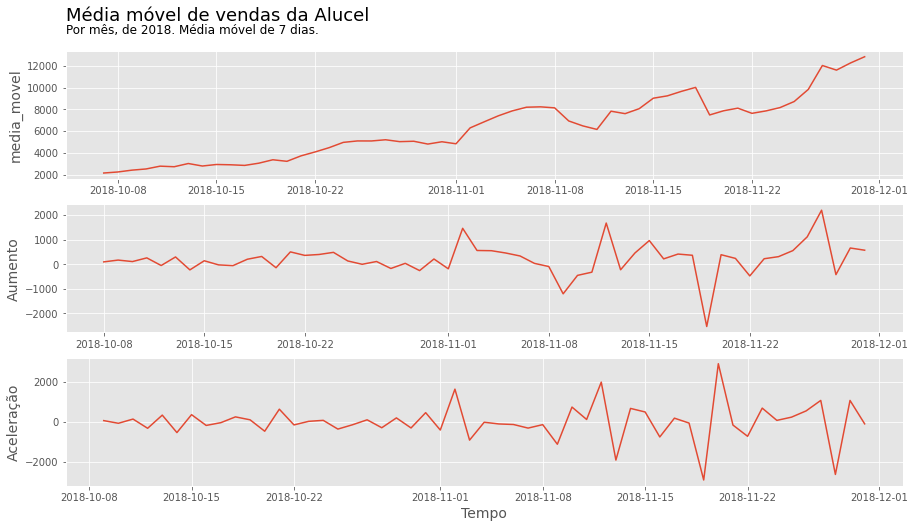

In [ ]:
alucel['media_movel'] = alucel['vendas'].rolling(7).mean()
comparacao_timeseries(alucel, 'media_movel', 'dia', 'Média móvel de vendas da Alucel', 'Por mês, de 2018. Média móvel de 7 dias.')

E vemos como nossa série temporal tem uma tendência bem mais clara. Podemos continuar aumentando o número de dias que queremos ver, porém temos que nos lembrar de que quanto maior o nosso intervalo, mais perdemos informação. Veja, por exemplo, o gráfico a seguir.

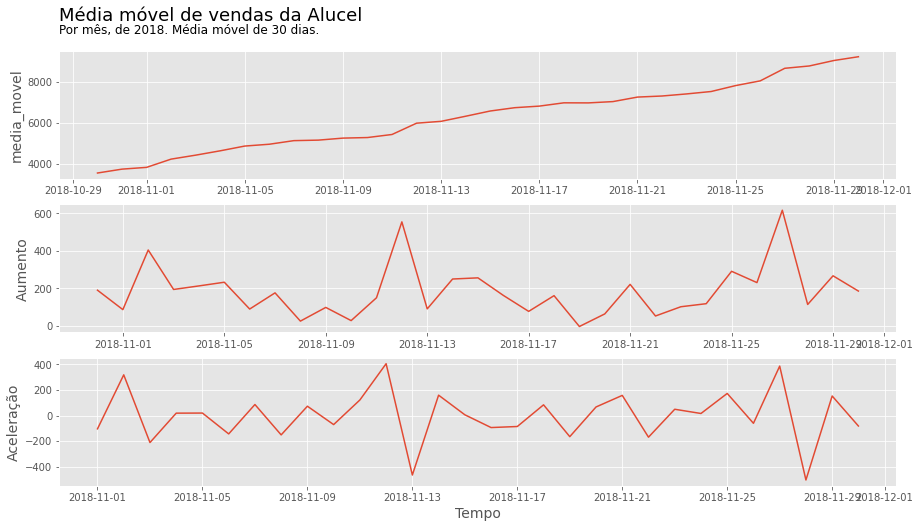

In [ ]:
alucel['media_movel'] = alucel['vendas'].rolling(30).mean()
comparacao_timeseries(alucel, 'media_movel', 'dia', 'Média móvel de vendas da Alucel', 'Por mês, de 2018. Média móvel de 30 dias.')

Veja que, além de termos menos pontos no gráfico, nossa linha já não tem mais as caracterísicas cruciais da linha original, apenas uma vaga tendência.